In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.qnn import TorchLayer
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA


from avalanche.benchmarks.classic import SplitMNIST
from avalanche.benchmarks import nc_benchmark
from avalanche.training.supervised import ER_ACE
from avalanche.training.plugins import EvaluationPlugin, LRSchedulerPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger
import pickle
import os
import numpy as np

2025-07-21 06:35:26.101498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-21 06:35:26.125589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-21 06:35:26.133060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 06:35:29.088767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

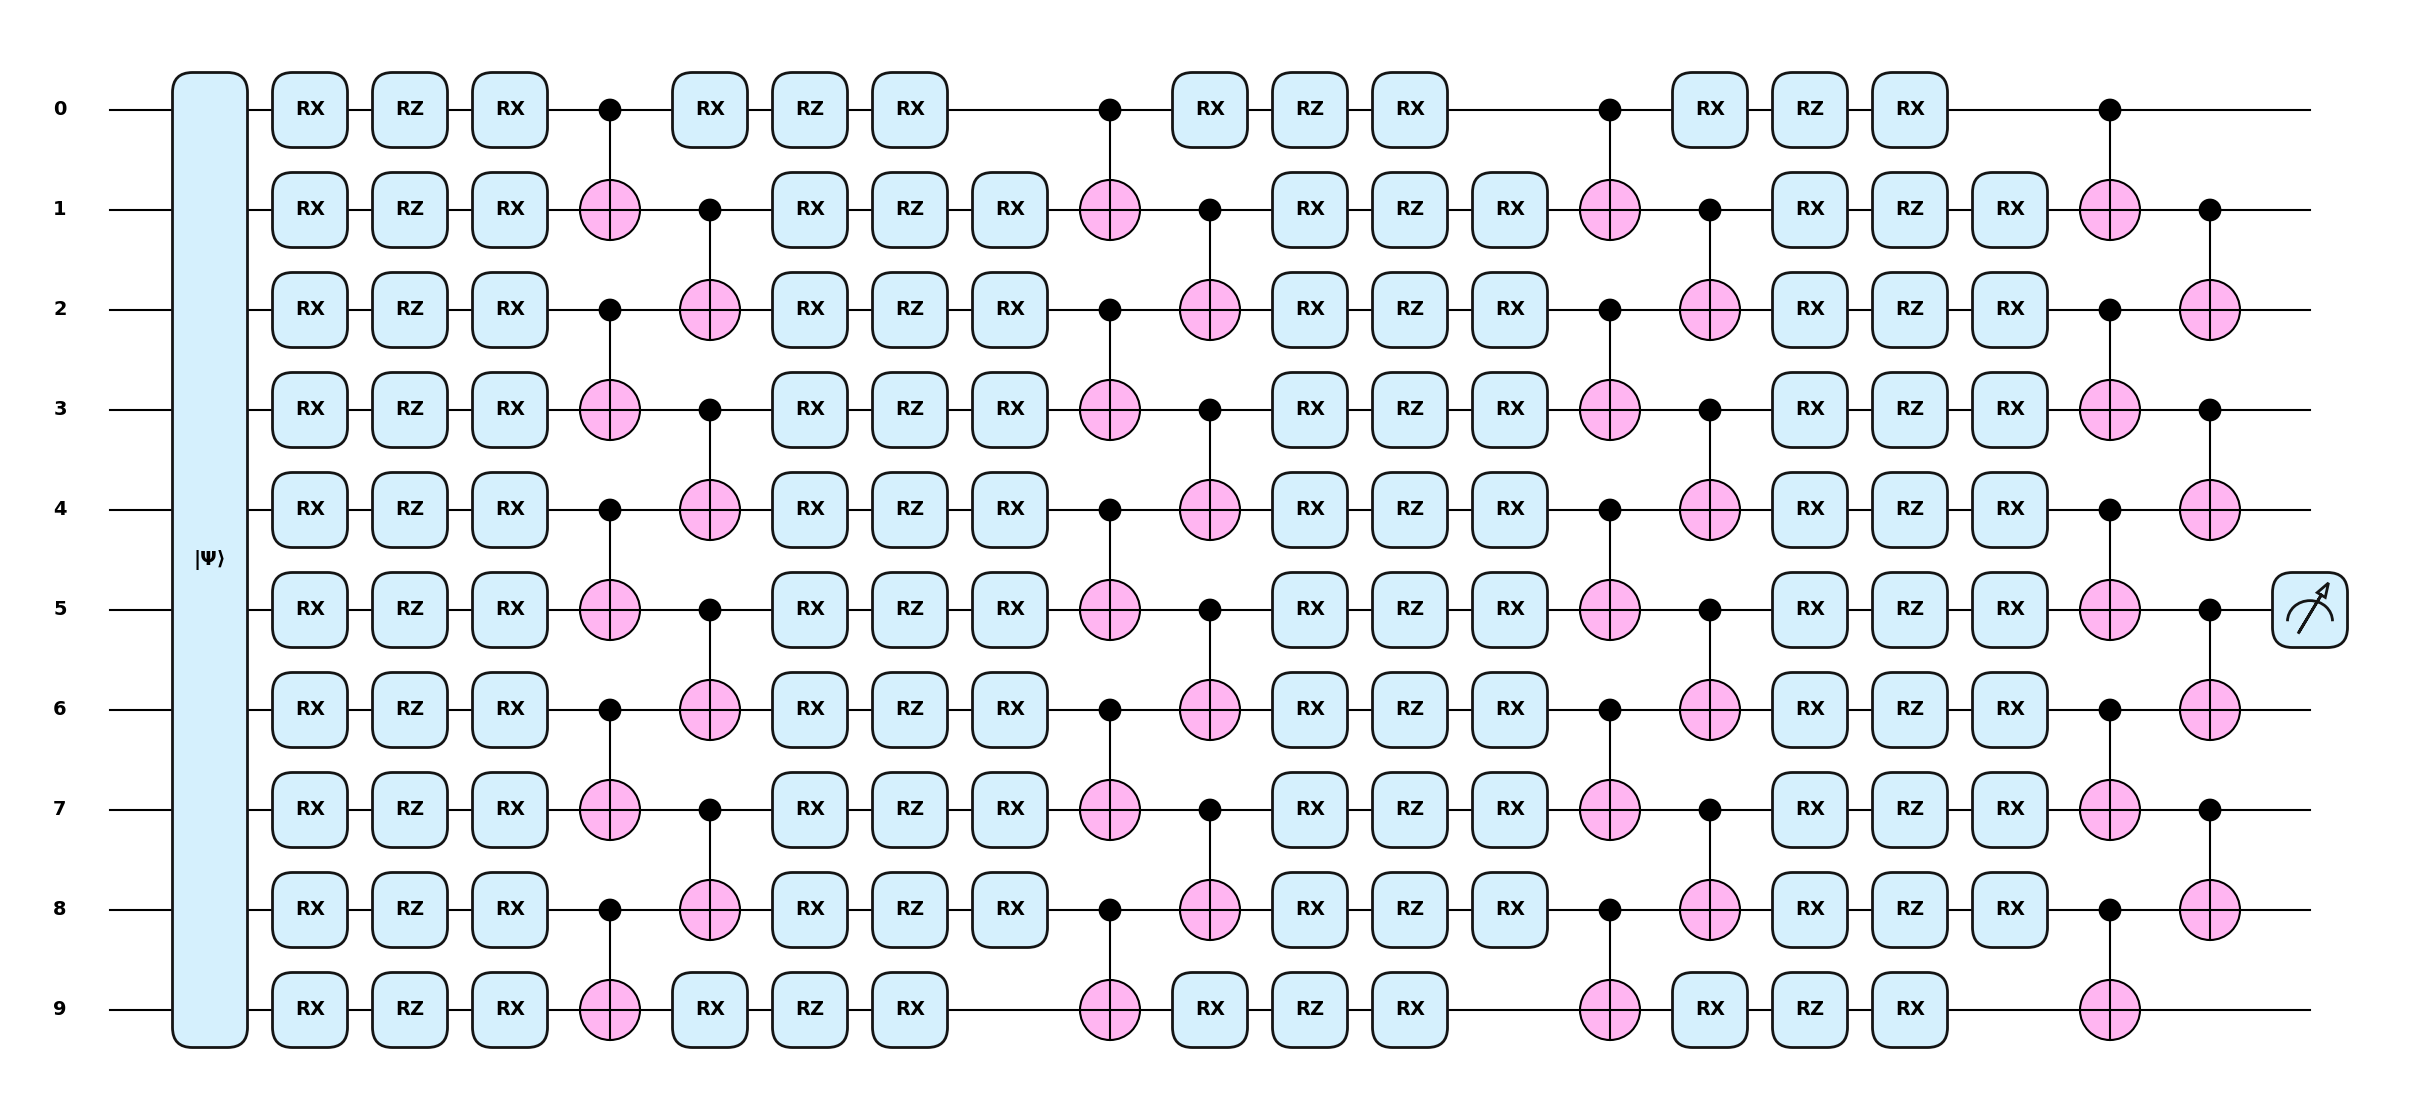

In [4]:
n_qubits = 10  # 10 个量子比特可以编码 2^10 = 1024 维数据
input_dim = 2**n_qubits  # 1024
n_layers = 4
dev = qml.device("lightning.qubit", wires=n_qubits)

# 定义量子电路 - 使用振幅编码
def quantum_circuit(inputs, weights):
    # 振幅编码 - 可以处理最多 1024 维输入
    inputs = qml.math.clip(inputs, -1.0, 1.0)
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    
    # 变分层
    for layer in range(n_layers):
        # 单比特旋转
        for i in range(n_qubits):
            qml.RX(weights[layer, i, 0], wires=i)
            qml.RZ(weights[layer, i, 1], wires=i)
            qml.RX(weights[layer, i, 2], wires=i)
        
        # 纠缠层
        # 交替连接：0-1, 2-3, 4-5, 6-7, 8-9
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        # 交替连接：1-2, 3-4, 5-6, 7-8
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
    
    # 测量中间量子比特
    return qml.expval(qml.PauliZ(n_qubits // 2))

# 绘制量子电路
qml.drawer.use_style("pennylane")
inputs = torch.randn(input_dim)  # 1024 维输入
weights = torch.randn(n_layers, n_qubits, 3)  # 权重形状：(4, 10, 3)
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()

In [4]:
# -----------------------------
# 1. 数据转换（调整维度到 1024）
# -----------------------------
def adjust_dimension(x):
    current_dim = x.shape[0]
    if current_dim < input_dim:
        # 填充0到1024维
        return F.pad(x, (0, input_dim - current_dim))
    elif current_dim > input_dim:
        # 截断到1024维
        return x[:input_dim]
    return x

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1)),  # 展平为784维
    transforms.Lambda(adjust_dimension),  # 调整到1024维
    transforms.Lambda(lambda x: torch.clamp(x, -1.0, 1.0))  # 确保在[-1,1]范围内
])

# 创建 benchmark
benchmark = SplitMNIST(
    n_experiences=5, 
    return_task_id=False,
    train_transform=transform, 
    eval_transform=transform
)

In [ ]:
# -----------------------------
# 2. 量子模型
# -----------------------------
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

class QuantumClassifier(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        qnode = qml.QNode(quantum_circuit, dev, interface="torch")
        self.q_layer = TorchLayer(qnode, weight_shapes)  # 默认在 CPU

        # 把经典输出层放到 GPU（或你选的 device）上
        self.output = nn.Linear(1, 10).to(self.device)

    def forward(self, x):
        # x 原本在 GPU 上，可以先在 GPU 做归一化之类的预处理
        x = x.to(self.device)
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        x = F.normalize(x, p=2, dim=1)

        # --- 关键：量子层必须在 CPU 上跑 ---
        x_cpu = x.cpu()
        out_cpu = self.q_layer(x_cpu)

        # 再把量子层的输出搬回 GPU
        x = out_cpu.to(self.device)

        x = x.unsqueeze(1)    # [batch, 1]
        x = self.output(x)    # 经典线性层
        return F.log_softmax(x, dim=1)

In [11]:
# -----------------------------
# 3. Avalanche 设置
# -----------------------------
model = QuantumClassifier(device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss().to(device)

interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=10, save_image=True, stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger]
)

In [14]:
# 8. 添加学习率调度器
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
lr_plugin = LRSchedulerPlugin(lr_scheduler)

# 9. 创建持续学习策略
strategy = ER_ACE(
    model,
    optimizer,
    criterion,
    train_mb_size=64,           # 训练批次大小
    eval_mb_size=128,            # 评估批次大小
    train_epochs=20,             # 增加训练轮数
    plugins=[lr_plugin],
    evaluator=eval_plugin,
    device=device,
    # eval_every=1                 # 每个epoch后都评估
)

# 日志记录
interactive_logger = InteractiveLogger()
# text_logger = TextLogger(open('ewc_splitmnist.log', 'w'))
# tb_logger = TensorboardLogger('ewc_tb_logs')
strategy.evaluator.loggers = [interactive_logger]

  0%|          | 0/96 [02:05<?, ?it/s]


In [15]:
# -----------------------------
# 5. Training & Accuracy Recording
# -----------------------------
task_accuracies = []

for experience in benchmark.train_stream:
    print(f"\n--- Training on experience {experience.current_experience} ---")
    strategy.train(experience)

    print("--- Evaluating on test stream ---")
    results = strategy.eval(benchmark.test_stream)

    task_accuracies.append(results)


--- Training on experience 0 ---
-- >> Start of training phase << --
0it [00:00, ?it/s]

  1%|          | 1/191 [00:05<17:34,  5.55s/it]

KeyboardInterrupt: 

In [ ]:
# Define the file path
file_path = "/home/yangz2/code/quantum_cl/results/list/splitminist_erace_s2_qbit10_qdepth4.pkl"

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)  # <-- Add this line   

In [ ]:
# 存储到文件
with open(file_path, "wb") as f:
    pickle.dump([task_accuracies], f) 